In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
import seaborn as sns
from datetime import datetime, timedelta

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
from scipy import stats
import statsmodels.api as sm
from itertools import product

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date',date_parser=dateparse)
df.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [8]:
# extracting the bitcoin data

btc = df[df['symbol']=='BTC']

# dropping some columns
btc.drop(['slug','symbol','name','ranknow','volume','market','close_ratio','spread'],axis=1,inplace=True)

In [9]:
print(len(btc))

1761


In [48]:
btc_month = btc.resample('M').mean()

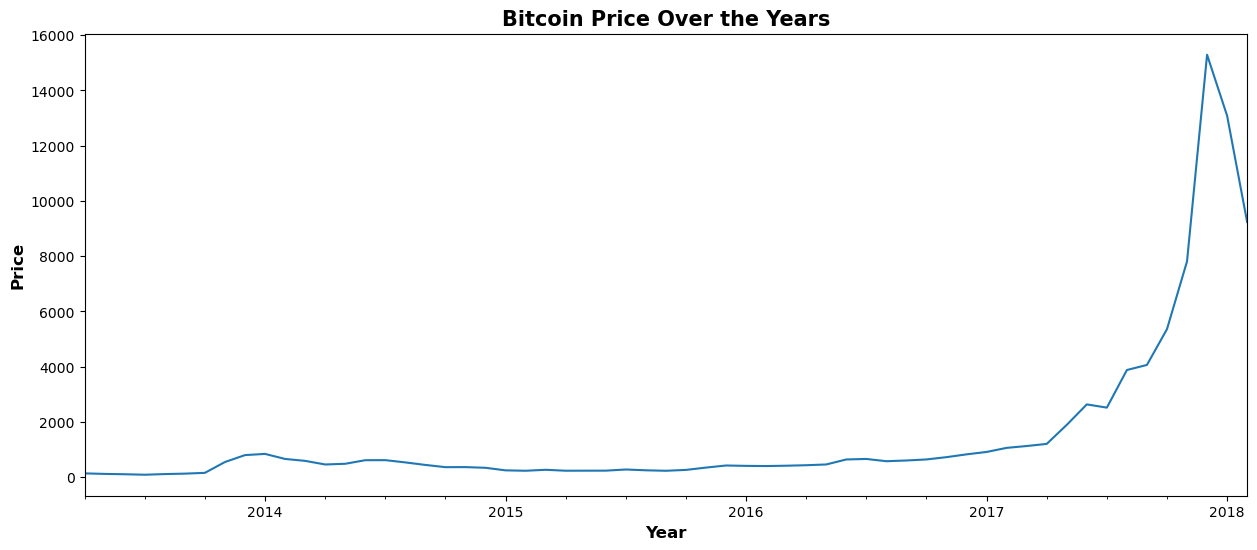

In [52]:
btc_month['close'].plot(figsize=(15, 6))
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years', fontsize=15, fontweight='bold')
plt.show()

# 1. Plotting Rolling Average and Rolling Standard Deviations

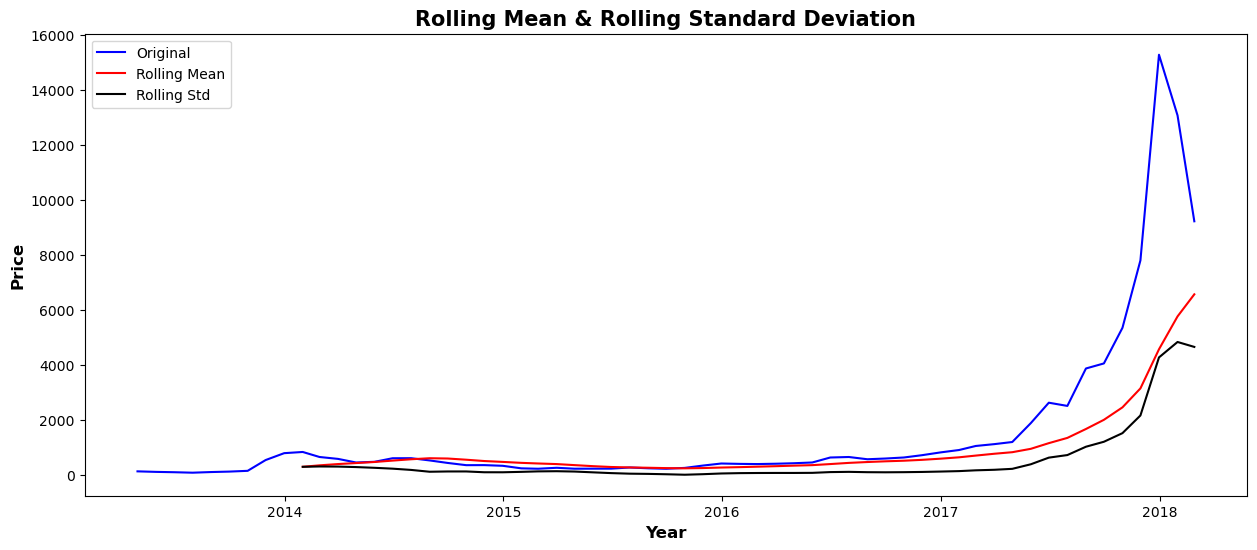

In [54]:
# plotting rolling average
window_size = 10
rolling_mean = btc_month['close'].rolling(window=window_size).mean()
rolling_std = btc_month['close'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc_month['close'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

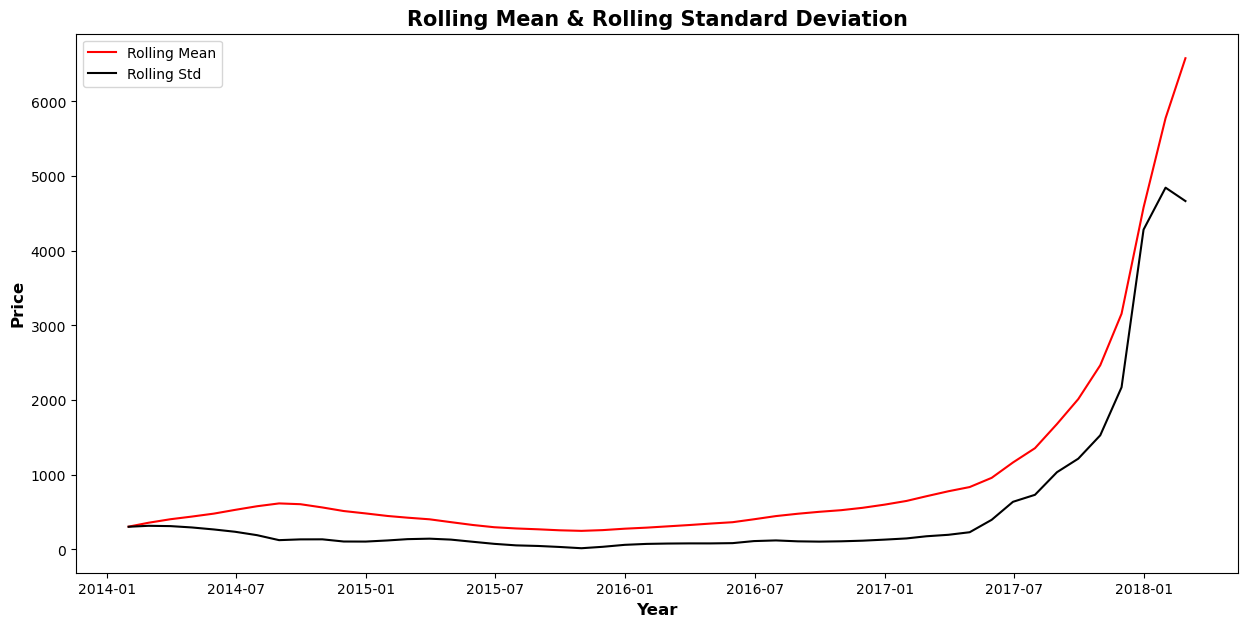

In [55]:
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

# Checking If the Rolling Average and Rolling Standard Deviation are Stationary

In [63]:
print('ADF p-value for Rolling Mean: %f' % adfuller(rolling_mean.dropna())[1])
print('ADF p-value for Rolling Std: %f' % adfuller(rolling_std.dropna())[1])

ADF p-value for Rolling Mean: 1.000000
ADF p-value for Rolling Std: 0.996607


### Since the p-value is greater than 0.05, we fail to reject the null hypothesis. The rolling average and rolling standard deviation are not stationary.

# 2. Plotting the Autocorrelation

<Figure size 1500x600 with 0 Axes>

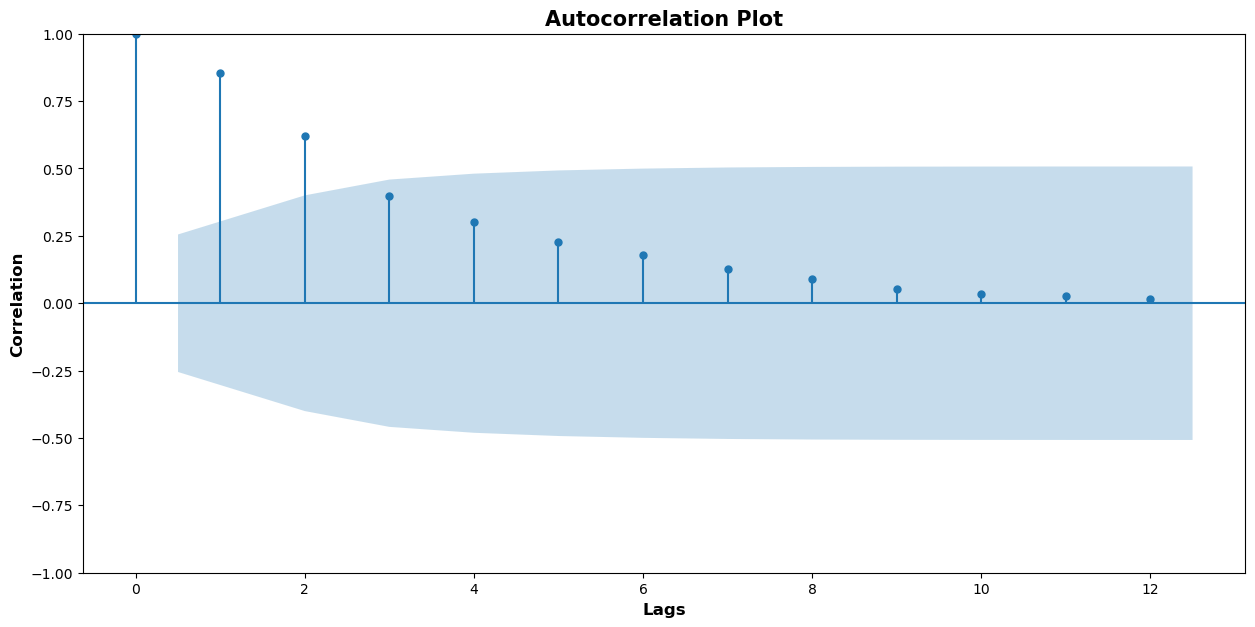

In [57]:
# plotting the autocorrelation plot
plt.figure(figsize=(15,6))
plot_acf(btc_month['close'], lags=12)
plt.xlabel('Lags', fontsize=12, fontweight='bold')
plt.ylabel('Correlation', fontsize=12, fontweight='bold')
plt.title('Autocorrelation Plot', fontsize=15, fontweight='bold')
plt.show()

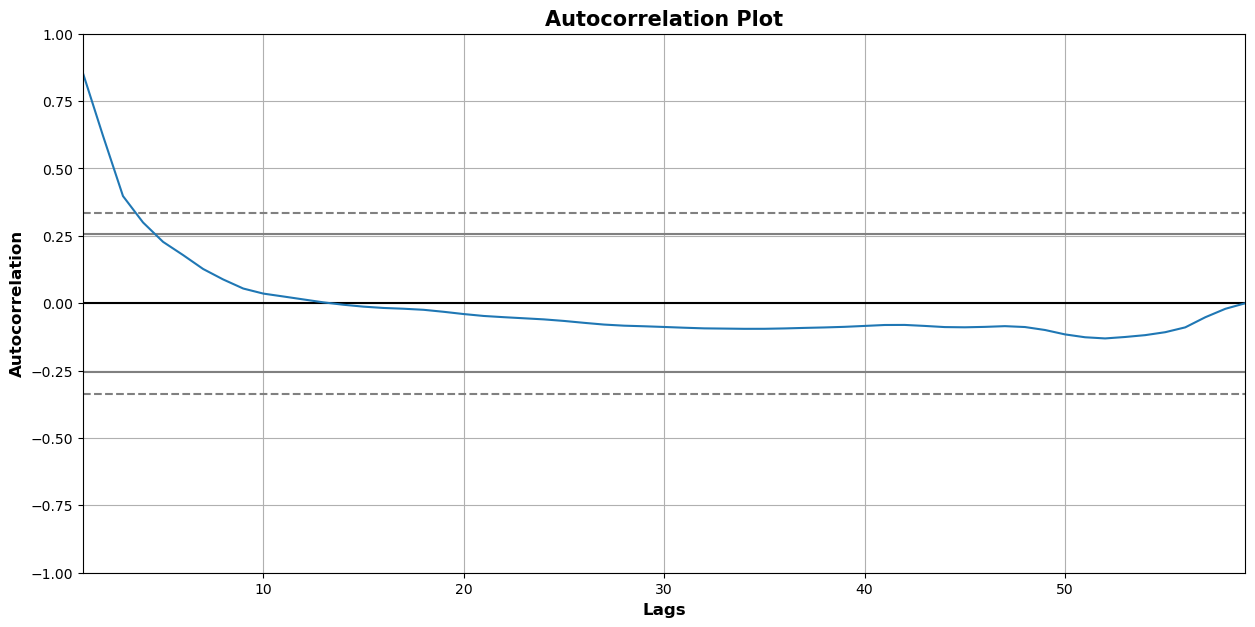

In [58]:
pd.plotting.autocorrelation_plot(btc_month['close'])
plt.xlabel('Lags', fontsize=12, fontweight='bold')
plt.ylabel('Autocorrelation', fontsize=12, fontweight='bold')
plt.title('Autocorrelation Plot', fontsize=15, fontweight='bold')
plt.show()

### From the ACF plots, we see that the rolling average and rolling standard deviation are not stationary as there are some values that are outside the confidence interval.

# 3. Removing Seasonality

### We remove seasonality by differencing the data. We take the difference between the current value and the previous value.
### Another way of doing this is by using BoxCox Transformation. This is a way of transforming non-normal dependent variables into a normal shape. This is done by raising each value in the dependent variable by a power. The power, lambda, varies from -5 to 5. In the end, the lambda that achieves the best approximation to normality is chosen. Here, we have used the BoxCox Transformation to remove seasonality.

Lambda: -0.313277


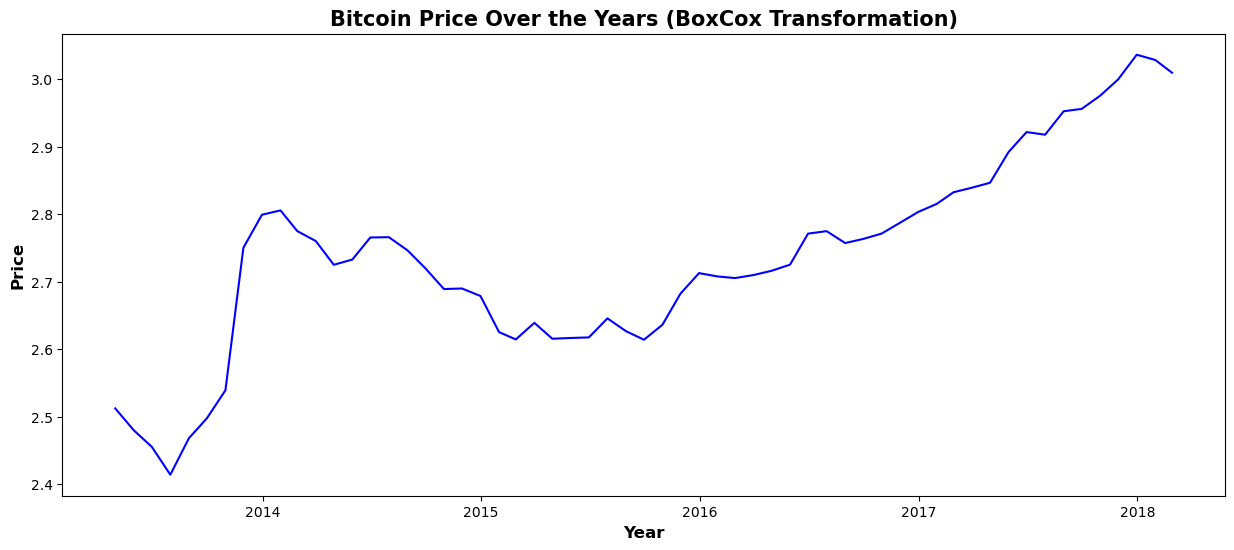

In [59]:
# removing seasonality with boxcox transformation
btc_month['close_boxcox'], lam = stats.boxcox(btc_month['close'])

print('Lambda: %f' % lam)
plt.figure(figsize=(15,6))
plt.plot(btc_month['close_boxcox'], color='blue')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years (BoxCox Transformation)', fontsize=15, fontweight='bold')
plt.show()

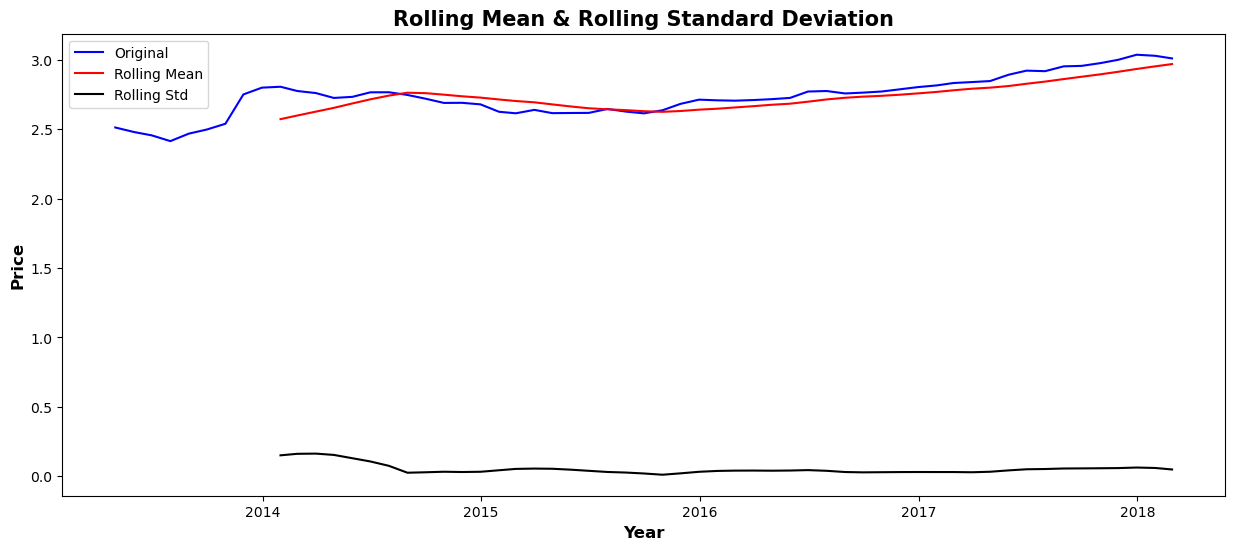

In [64]:
# plotting rolling average and rolling standard deviation
window_size = 10
rolling_mean = btc_month['close_boxcox'].rolling(window=window_size).mean()
rolling_std = btc_month['close_boxcox'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc_month['close_boxcox'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

In [65]:
adfuller(btc_month['close_boxcox'])[1]

0.5136392090562125

### With a value of 0.5136, we see that the data is not stationary but the seasonality has been lessened compared to before. 

<Figure size 1500x700 with 0 Axes>

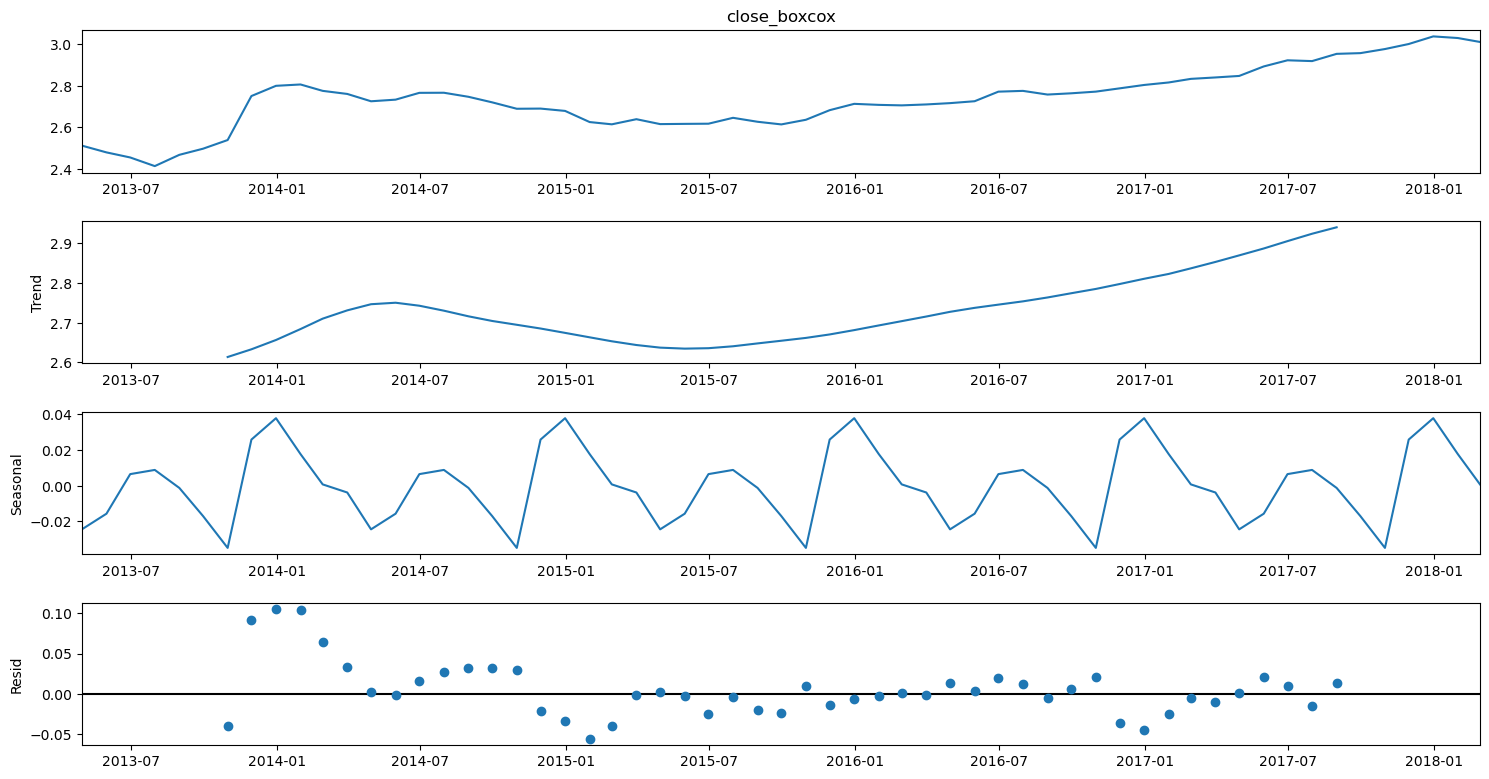

In [69]:
# using seasonal decomposition to remove seasonality
decomposition = seasonal_decompose(btc_month['close_boxcox'], model='additive', period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

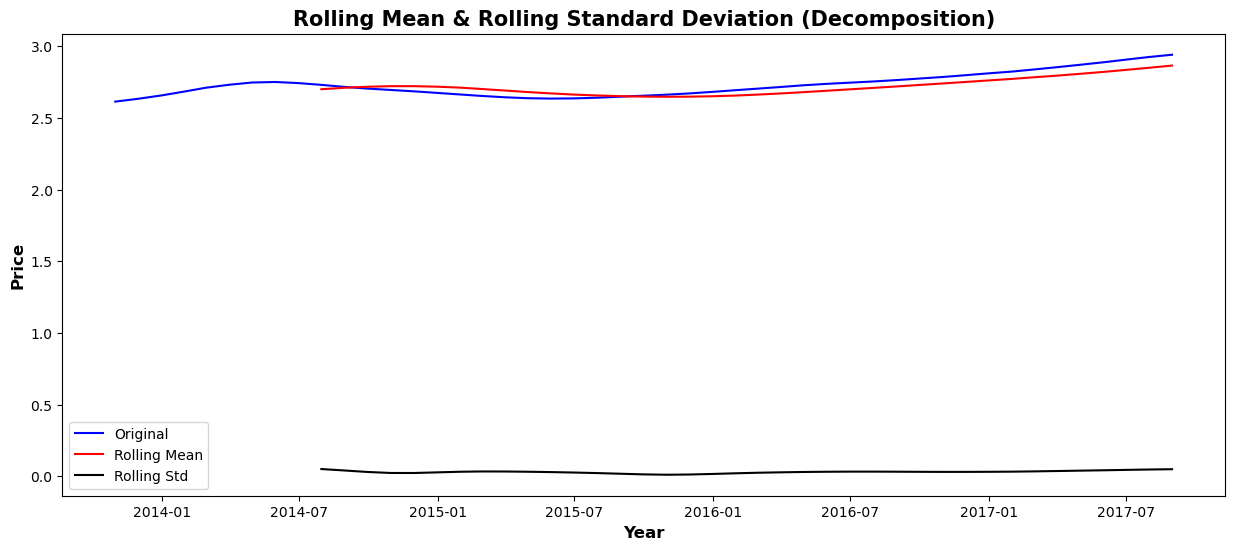

In [70]:
# plotting rolling average and rolling standard deviation
window_size = 10
rolling_mean = decomposition.trend.rolling(window=window_size).mean()
rolling_std = decomposition.trend.rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(decomposition.trend, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation (Decomposition)', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                 1761
Model:                 ARIMA(1, 1, 0)   Log Likelihood                6350.225
Date:                Thu, 11 May 2023   AIC                         -12696.449
Time:                        12:54:29   BIC                         -12685.503
Sample:                    04-28-2013   HQIC                        -12692.404
                         - 02-21-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0011      0.011     -0.101      0.920      -0.022       0.020
sigma2      4.295e-05   5.68e-07     75.570      0.000    4.18e-05    4.41e-05
Ljung-Box (L1) (Q):                   0.01   Jarque-

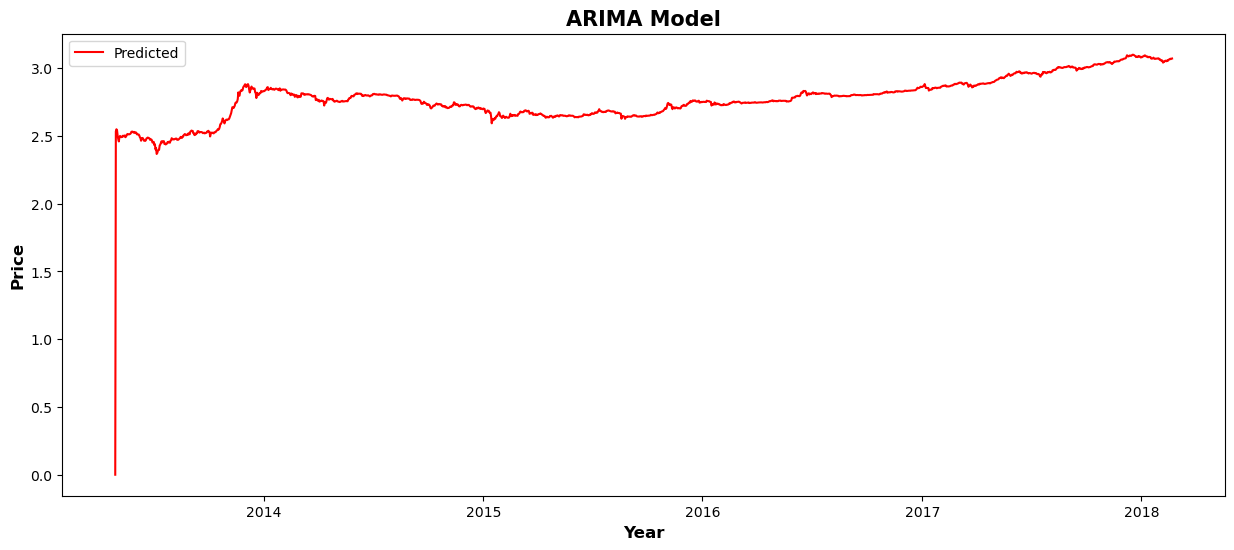

In [28]:
# fitting an arima model
model = ARIMA(btc['close_boxcox'], order=(1, 1, 0))
results = model.fit()
print(results.summary())
plt.figure(figsize=(15,6))
plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                 1761
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6350.300
Date:                Thu, 11 May 2023   AIC                         -12694.601
Time:                        12:55:24   BIC                         -12678.182
Sample:                    04-28-2013   HQIC                        -12688.533
                         - 02-21-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0007      0.011      0.068      0.946      -0.021       0.022
ar.L2         -0.0094      0.013     -0.744      0.457      -0.034       0.015
sigma2      4.294e-05   5.75e-07     74.638      0.0

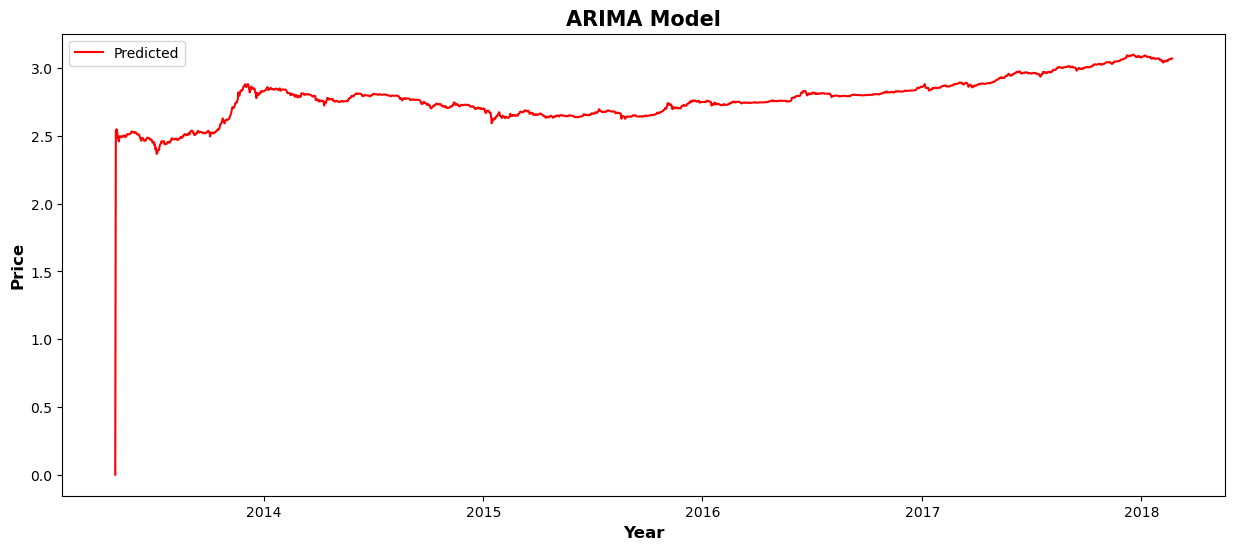

In [29]:
# fitting an arima model
model = ARIMA(btc['close_boxcox'], order=(2, 1, 0))
results = model.fit()
print(results.summary())
plt.figure(figsize=(15,6))
plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                 1761
Model:                 ARIMA(0, 1, 2)   Log Likelihood                6350.111
Date:                Thu, 11 May 2023   AIC                         -12694.221
Time:                        12:56:14   BIC                         -12677.802
Sample:                    04-28-2013   HQIC                        -12688.153
                         - 02-21-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0156      0.011     -1.411      0.158      -0.037       0.006
ma.L2         -0.0061      0.013     -0.480      0.631      -0.031       0.019
sigma2      4.301e-05   5.77e-07     74.495      0.0

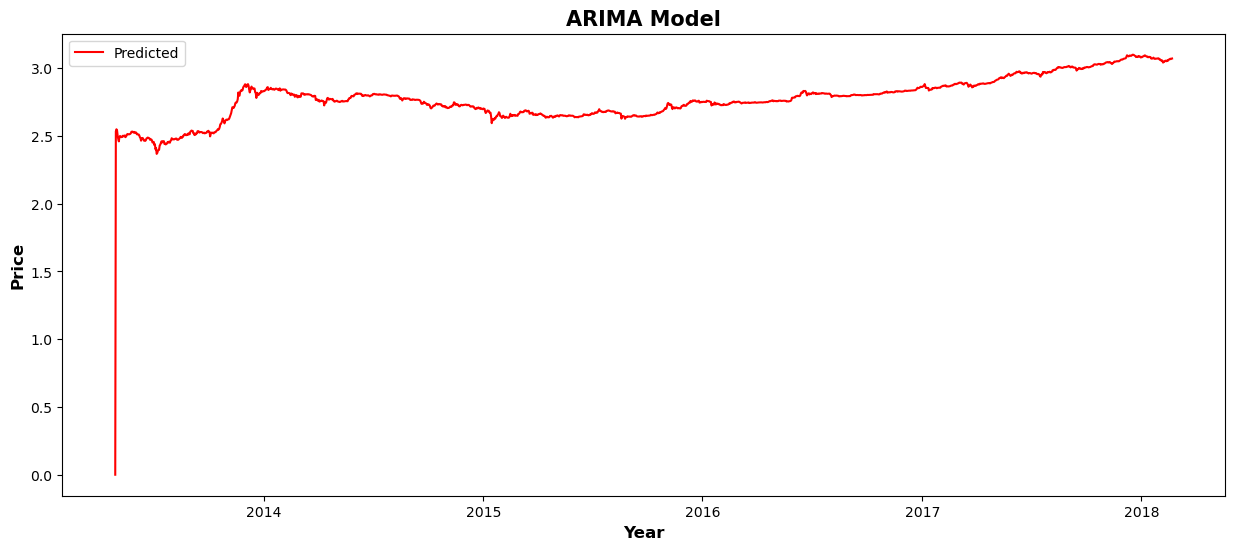

In [30]:
# fitting an arima model
model = ARIMA(btc['close_boxcox'], order=(0, 1, 2))
results = model.fit()
print(results.summary())
plt.figure(figsize=(15,6))
plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                 1761
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6350.224
Date:                Thu, 11 May 2023   AIC                         -12694.448
Time:                        12:56:28   BIC                         -12678.029
Sample:                    04-28-2013   HQIC                        -12688.380
                         - 02-21-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -4.598e-08      0.005   -8.6e-06      1.000      -0.010       0.010
ma.L1       -4.64e-08      0.005  -8.67e-06      1.000      -0.010       0.010
sigma2      4.296e-05   5.69e-07     75.536      0.0

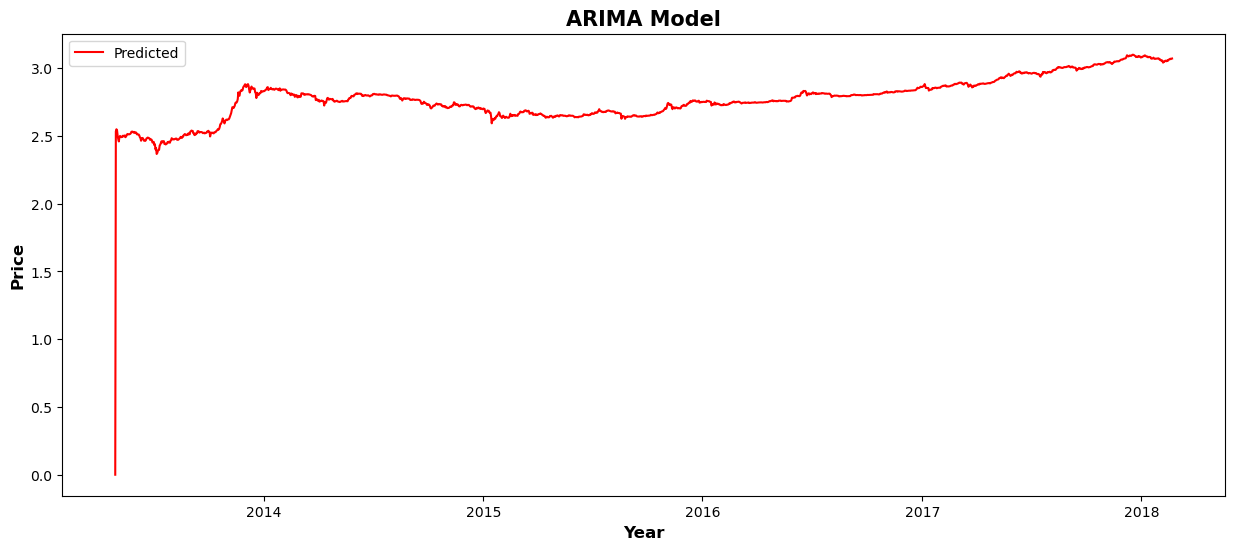

In [31]:
# fitting an arima model
model = ARIMA(btc['close_boxcox'], order=(1, 1, 1))
results = model.fit()
print(results.summary())
plt.figure(figsize=(15,6))
plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

In [32]:
def invboxcox(y, lam):
   if lam == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lam*y+1)/lam))

In [34]:
# plotting the prediction prices and the original prices

# using the inverse boxcox function to get the original prices
predictions = invboxcox(results.fittedvalues, lam)

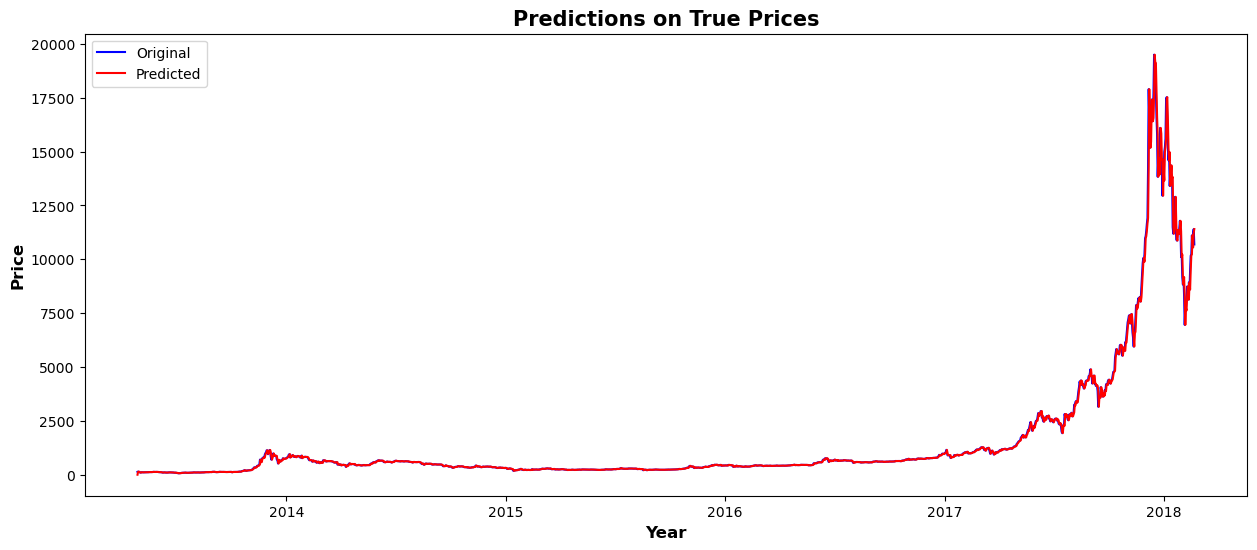

In [39]:
# plotting the original prices
plt.figure(figsize=(15,6))
plt.plot(btc['close'], color='blue', label='Original')
plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('Predictions on True Prices', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

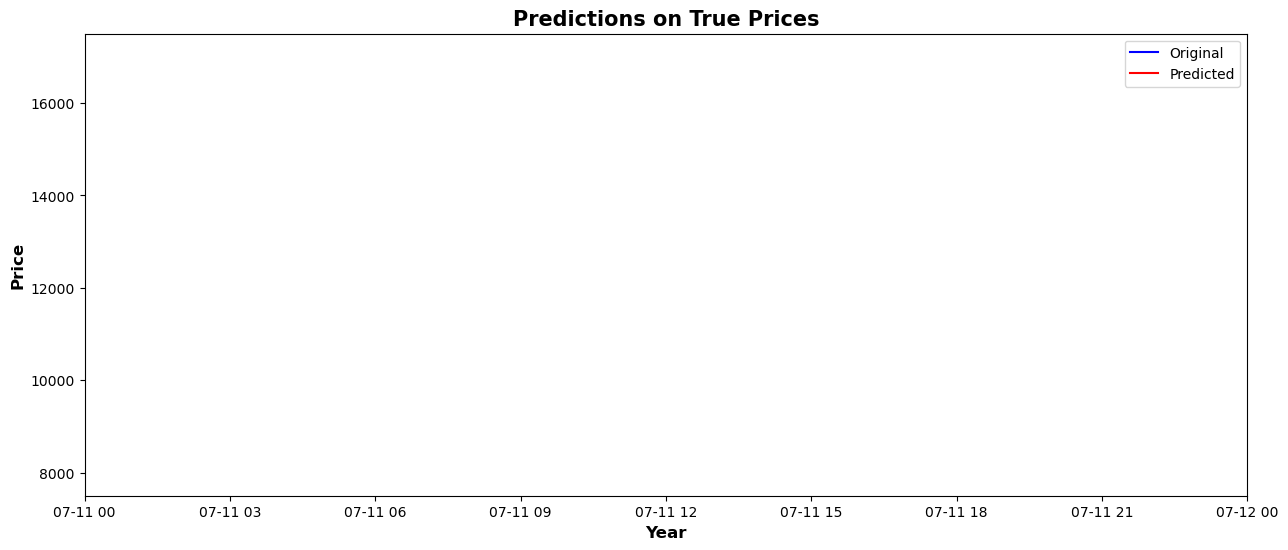

In [40]:
plt.figure(figsize=(15,6))
plt.plot(btc['close'], color='blue', label='Original')
plt.plot(predictions, color='red', label='Predicted')
plt.xlim(2017, 2018)
plt.ylim(7500, 17500)
plt.legend(loc='best')
plt.title('Predictions on True Prices', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()